## B样条基函数

### 数学公式

假设我们有一个B样条基函数的阶数为 $ k $（即多项式的度数为 $ k $），节点向量为 $ \mathbf{t} = [t_0, t_1, \dots, t_{n+k}] $，其中 $ n $ 是样条的数量。B样条基函数 $ N_{i,k}(x) $ 可以递归地定义如下：

- **阶数为0的基函数**：
  $$
  N_{i,0}(x) = 
  \begin{cases} 
  1 & \text{if } t_i \leq x < t_{i+1} \\
  0 & \text{otherwise}
  \end{cases}
  $$

- **阶数为 $ k $ 的基函数**：
  $$
  N_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} N_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(x)
  $$

这个公式表明，阶数 $ k $ 的基函数是阶数 $ k-1 $ 的基函数的线性组合。

### Python代码示例

下面是一个Python代码示例，使用 `numpy` 和 `matplotlib` 来计算和可视化B样条基函数：

tensor([0.0000, 0.0909, 0.1818, 0.2727, 0.3636, 0.4545, 0.5455, 0.6364, 0.7273,
        0.8182, 0.9091, 1.0000])


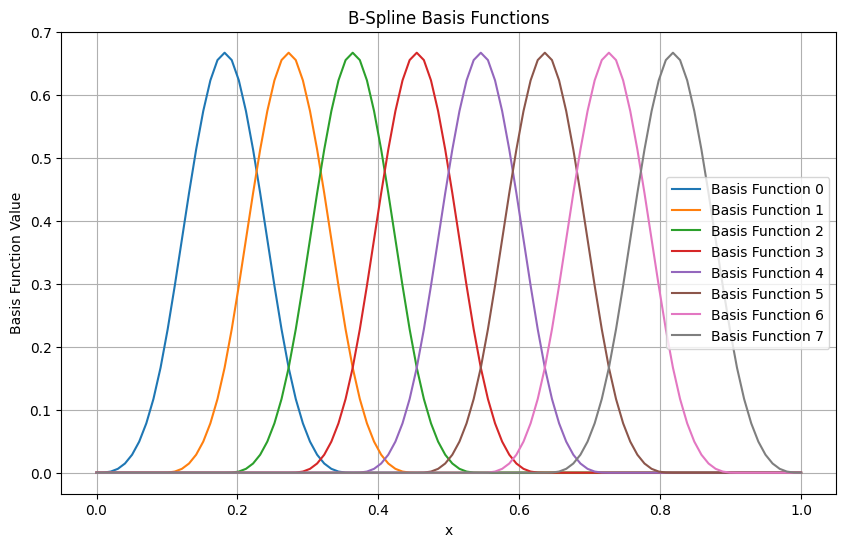

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


def b_spline_basis(x, knots, k):
    """
    使用递归公式计算B样条基函数。
    
    参数:
    - x: torch.tensor, x值的张量
    - knots: torch.tensor, 节点向量
    - k: int, B样条的阶数
    
    返回:
    - basis: torch.tensor, B样条基函数的值
    """
    n = knots.size(0) - k - 1
    basis = torch.zeros(n, x.size(0))
    
    def basis_function(i, k, x):
        if k == 0:
            return ((x >= knots[i]) & (x < knots[i+1])).float()
        else:
            denom1 = knots[i+k] - knots[i]
            denom2 = knots[i+k+1] - knots[i+1]
            coef1 = (x - knots[i]) / denom1 if denom1 != 0 else 0
            coef2 = (knots[i+k+1] - x) / denom2 if denom2 != 0 else 0
            return coef1 * basis_function(i, k-1, x) + coef2 * basis_function(i+1, k-1, x)
    
    for i in range(n):
        basis[i, :] = basis_function(i, k, x)
    
    return basis

# Parameters
num_splines = 8
k = 3  # Degree of the B-spline
knots = torch.linspace(0, 1, steps=num_splines + k + 1)  # Knot vector
print(knots)

# Generate x values
x = torch.linspace(0, 1, 100)

# Compute B-spline basis functions
basis = b_spline_basis(x, knots, k)

# Plot B-spline basis functions
plt.figure(figsize=(10, 6))
for i in range(basis.shape[0]):
    plt.plot(x, basis[i, :], label=f'Basis Function {i}')

plt.xlabel('x')
plt.ylabel('Basis Function Value')
plt.title('B-Spline Basis Functions')
plt.legend()
plt.grid(True)
plt.show()

### 代码说明
1. **函数 `b_spline_basis`**：
   - 计算给定节点向量和阶数的B样条基函数。
   - 使用递归公式计算基函数的值。

2. **参数设置**：
   - `knots` 是节点向量，定义了基函数的支持区间。
   - `k` 是B样条基函数的阶数。

3. **计算和可视化**：
   - 生成一组 `x` 值并计算相应的B样条基函数值。
   - 使用 `matplotlib` 绘制每个基函数的图形。

## B样条系数

B-spline coefficients（B样条系数）是与B样条基函数相乘的系数，用来构造整个B样条曲线或曲面。简单来说，B-spline coefficients 是定义曲线形状的权重值，它们决定了B样条曲线如何通过控制点或接近数据点。

### B样条曲线的定义

假设我们有一组B样条基函数 $ N_{i,k}(x) $ 和对应的B-spline coefficients $ c_i $，则B样条曲线 $ S(x) $ 可以表示为：

$$
S(x) = \sum_{i=0}^{n} c_i N_{i,k}(x)
$$

其中：
- $ N_{i,k}(x) $ 是阶数为 $ k $ 的第 $ i $ 个B样条基函数。
- $ c_i $ 是对应的B-spline coefficient，它决定了基函数 $ N_{i,k}(x) $ 在曲线中所占的权重。
- $ n $ 是B样条基函数的数量。

### 直观理解

- **B样条基函数**：它们像构造曲线的“积木”，每个基函数负责在一定区间内定义曲线的形状。
- **B样条系数**：这些系数控制了每个“积木”的重要性。较大的系数意味着对应的B样条基函数对最终曲线的贡献较大，而较小的系数则意味着贡献较小。

### 系数转曲线（coef2curve）

coefficients:  tensor([[-2.5023,  0.8756, -2.6726, -0.0313,  0.4988, -0.5233, -0.2515, -1.0555]])


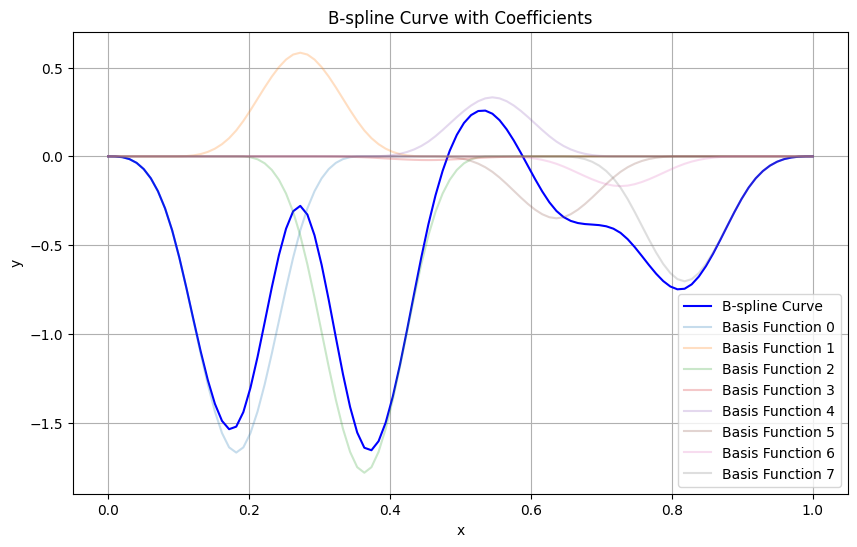

In [48]:
# 定义B-spline coefficients
coefficients = torch.normal(0, 1, size=(1, num_splines), dtype=torch.float32)
print("coefficients: ", coefficients)
# 构建B样条曲线
y = coefficients @ basis
basis_ = coefficients.T * basis

# 绘制B样条曲线
plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), y.flatten().numpy(), 'b-', label='B-spline Curve')
# plt.plot(knots.numpy(), coefficients.numpy(), 'ro--', label='Control Points')
plt.xlabel('x')
plt.ylabel('y')
for i in range(basis_.shape[0]):
    plt.plot(x, basis_[i, :], label=f'Basis Function {i}', alpha=0.25)
plt.title('B-spline Curve with Coefficients')
plt.legend()
plt.grid(True)
plt.show()


### 曲线转系数（curve2coef）

coefficients (predicted):  tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845, -1.3986,  0.4033,  0.8380])
coefficients error:  tensor(4.7684e-07)


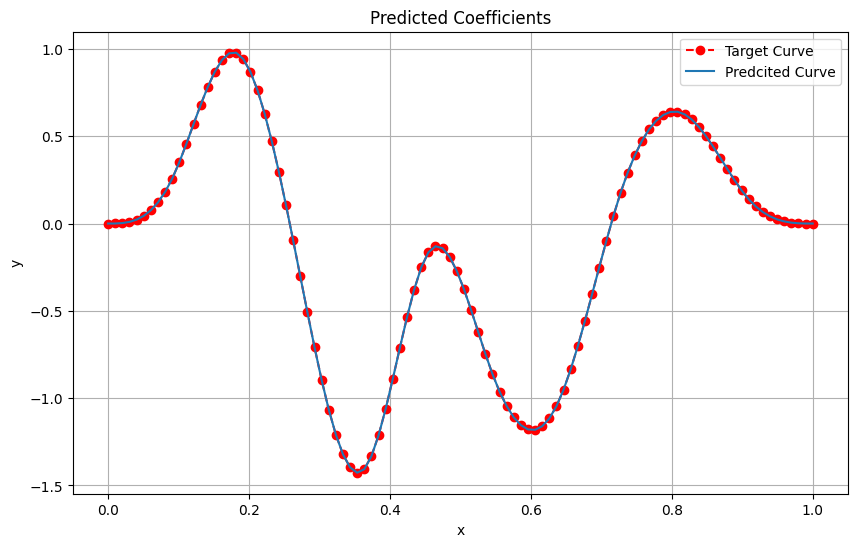

In [35]:
coef_hat = torch.linalg.lstsq(basis.T, y.expand(num_splines, 100).T, driver='gelsy' if basis.device == 'cpu' else 'gels').solution[..., 0]
print("coefficients (predicted): ", coef_hat)

# 构建B样条曲线
y_hat = torch.matmul(coef_hat, basis)
print("coefficients error: ", (coefficients - coef_hat).abs().max())

# 绘制B样条曲线
plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), y.flatten().numpy(), 'ro--', label='Target Curve')
plt.plot(x.numpy(), y_hat.numpy(), label='Predcited Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Coefficients')
plt.legend()
plt.grid(True)
plt.show()

### 结果

运行上述代码，你将看到一条B样条曲线，它由给定的控制点和B样条系数组合而成。通过调整 `coefficients` 的值，你可以改变曲线的形状。例如，增加某个系数的值会使曲线在该控制点附近上升或下降。

## Knots的问题

在B样条（B-spline）中，**knots** 是定义曲线如何分段的重要参数。它们是节点值的集合，决定了B样条基函数的支撑区间，也就是说，knots 划分了曲线的定义域，使其分成若干段，每段由一个多项式表示。

### 1. 什么是 Knots?

**Knots** 是一个非递减的数列，用来分割曲线的定义域，定义每个多项式的作用区间。假设我们有一个节点向量 \( t \)（或叫 knot vector），则它可以表示为：

$$
t = [t_0, t_1, t_2, \dots, t_m]
$$

其中 $ t_i $ 表示第 $ i $ 个节点值，且 $ t_0 \leq t_1 \leq t_2 \leq \dots \leq t_m $。

### 2. Knots 的作用

- **定义分段区间**: B样条曲线由多段多项式拼接而成，每段多项式的区间由 `knots` 确定。
- **影响曲线的光滑度**: 连续多次出现的同一个节点会降低曲线在该节点的连续性。例如，重复的节点可以用来强制B样条曲线通过特定的控制点。
- **决定B样条基函数的支撑范围**: 每个B样条基函数只在一个有限的区间内非零，这个区间由 `knots` 决定。

### 3. Knot Vector 的类型

- **均匀节点向量（Uniform Knot Vector）**: 节点之间的间距相等。例如，`[0, 1, 2, 3, 4, 5]`。
- **非均匀节点向量（Non-Uniform Knot Vector）**: 节点之间的间距不相等。
- **开节点向量（Open Knot Vector）**: 节点向量的开头和结尾有多个相同的节点值，这样可以保证B样条曲线通过第一个和最后一个控制点。例如，`[0, 0, 0, 1, 2, 3, 3, 3]`。

### 4. 示例

假设我们有以下节点向量：

```python
import torch

# 一个简单的节点向量示例
knots = torch.tensor([0, 0, 0, 1, 2, 3, 4, 4, 4], dtype=torch.float32)
```

- 在这个例子中，`knots` 定义了从 `0` 到 `4` 的分段区间。
- 节点 `0` 和 `4` 在向量中重复了三次，这意味着B样条曲线在区间的开始和结束是“钉住”的（曲线通过首尾的控制点）。

### 5. 与 B 样条基函数的关系

每个B样条基函数 $ N_{i,k}(x) $ 都依赖于节点向量和阶数 $ k $。`knots` 定义了这些基函数在何处开始和结束对曲线的贡献。

## 扩展网格点（Extended Grid Points）

在 B-spline 插值过程中，基函数的支持区间（即基函数非零的区域）通常会超出原始网格的范围。为了确保 B-spline 在整个插值区间内的表现足够平滑，我们需要在原始网格的两端延伸，以提供足够的支持。

例如，对于三次 B-spline（k=3），每个 B-spline 基函数在计算时需要包含 4 个控制点。如果不进行扩展，边界处的基函数将无法正确计算，从而导致插值效果不理想。


### 扩展网格点的计算
扩展网格点的计算方式如下：

- **步长计算**：首先计算网格的步长 $h$，即相邻网格点之间的距离。
- **左端扩展**：在网格左端，按照步长 $h$ 向左延伸，添加 k_extend 个点。
- **右端扩展**：在网格右端，按照步长 $h$ 向右延伸，添加 k_extend 个点。

假设原始网格为 $[x_0, x_1, ..., x_n]$，通过扩展后，新的网格变为$[x_0-k*h, ..., x_0-h, x_0, x_1, ..., x_n, x_n+h, ..., x_n+k*h]$。

### 扩展网格点的作用
**消除边界效应**：通过添加额外的网格点，B-spline 基函数在边界处能够平滑过渡，避免出现不连续或不准确的拟合。
**提高计算稳定性**：扩展网格点使得 B-spline 的支持区间足够大，保证了计算的稳定性，特别是在高阶 B-spline 中尤为重要。

In [ ]:
def extend_grid(grid, k_extend=0, device='cpu'):
    """
    扩展网格点的函数
    
    参数:
    - grid : torch.tensor, 输入的网格点，形状为 (batch_size, grid_points)
    - k_extend : int, 扩展的网格点数
    - device : str, 执行设备 ('cpu' 或 'cuda')
    
    返回:
    - torch.tensor, 扩展后的网格点，形状为 (batch_size, grid_points + 2*k_extend)
    """
    # 计算步长 h
    h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)

    for i in range(k_extend):
        # 扩展左端
        grid = torch.cat([grid[:, [0]] - h, grid], dim=1)
        # 扩展右端
        grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)
    
    # 将扩展后的网格移至指定设备
    grid = grid.to(device)
    
    return grid


In [ ]:
# 扩展网格点
extended_grid = extend_grid(knots.unsqueeze(0), k_extend=k)

# 计算 B-spline 基函数
basis = b_spline_basis(x, extended_grid.squeeze(), k)

# 可视化结果
for i in range(basis.size(0)):
    plt.plot(x.numpy(), basis[i].numpy(), label=f'B-spline basis {i}')

plt.figure(figsize=(10, 6))
plt.title('B-spline Basis Functions with Extended Grid')
plt.xlabel('x')
plt.ylabel('Basis Value')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 构建B样条曲线
coefficients = torch.normal(0, 1, size=(num_splines,), dtype=torch.float32)
y = torch.matmul(coefficients, basis)

# 绘制B样条曲线
plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), y.numpy(), label='B-spline Curve')
plt.plot(np.linspace(1 / num_splines, (num_splines - 1) / num_splines, len(coefficients)), coefficients.numpy(), 'ro--', label='Control Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('B-spline Curve with Coefficients')
plt.legend()
plt.grid(True)
plt.show()